In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

sys.path.append(str(Path().cwd().parent))

In [3]:
import load_dataset
from plotting import plot_ts

### Возьмем из датасета ряд с минимальными температурами.

In [4]:
dataset = load_dataset.Dataset('../data/dataset/')

In [5]:
ts = dataset['daily-min-temperatures.csv']
ts.index.name='data'
ts.rename('temp', inplace=True)

data
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
1981-01-06    15.8
              ... 
1990-12-27    14.0
1990-12-28    13.6
1990-12-29    13.5
1990-12-30    15.7
1990-12-31    13.0
Name: temp, Length: 3649, dtype: float64

In [6]:
ts.head()

data
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
1981-01-06    15.8
Name: temp, dtype: float64

In [7]:
ts.tail()

data
1990-12-27    14.0
1990-12-28    13.6
1990-12-29    13.5
1990-12-30    15.7
1990-12-31    13.0
Name: temp, dtype: float64

In [8]:
plot_ts(ts)

Loading BokehJS ...

## Поэтапное построение самого базового пайплайна для прогнозирования

### Задание 1.

Напишите функцию transform_to_matrix, которая бы принимала одномерный ряд и возвращала матрицу лагов

1. Функция должна принимать временной ряд (pd.Series) и количество лагов (оно же количество признаков). 

2. Функция должна проходить по ряду скользящим окном с шириной num_lags и брать лаги текущего окна в качестве признаков, а следующую точку в качестве ответа на данном обьекте.
3. Каждое перемещение окна на одну точку вперед сооветствует новому обьекту матрицы.
4. Функция должная вернуть pd.Dataframe - т.е. матрицу объекты признаки.

In [9]:
import pandas as pd
import numpy as np

In [78]:
def transform_to_matrix(ts, num_lags):
    ts_array = ts.values
    ts_dict = {}
    for i in range(num_lags+1):
        ts_dict[f'lag_{num_lags-i}'] = np.roll(ts_array, -i)
    ts_df = pd.DataFrame(ts_dict, index=ts.index)
    return ts_df[:-num_lags]

In [117]:
#мой вариант
def transform_to_matrix1(ts, num_lags):
    x_ = []
    ts_array = ts.values
    for i in range (len(ts_array)-num_lags):
        x_.append(ts_array[i:num_lags+i+1])

    ts_df = pd.DataFrame(x_,
                    columns=[f'lag_{i}' for i in range(num_lags,-1,-1)],
                    index=ts.index[:-num_lags]) 
    return ts_df   

In [120]:
%%time
df = transform_to_matrix(ts, 720)

Wall time: 153 ms


In [121]:
%%time
df1 = transform_to_matrix1(ts, 720)

Wall time: 1.3 s


In [122]:
df.compare(df1)

data


### Задание 2.

Получите матрицу обьекты-признаки, выбрав в качестве ориентировочного значения num_lags период сезонности ряда.

In [290]:
df = transform_to_matrix(ts, 365)
df.head()

,lag_365,lag_364,lag_363,lag_362,lag_361,lag_360,lag_359,lag_358,lag_357,lag_356,...,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,lag_0
data,,,,,,,,,,,,,,,,,,,,,
1981-01-02,17.9,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,...,15.0,14.2,14.0,15.5,13.3,15.6,15.2,17.4,17.0,15.0
1981-01-03,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,...,14.2,14.0,15.5,13.3,15.6,15.2,17.4,17.0,15.0,13.5
1981-01-04,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,...,14.0,15.5,13.3,15.6,15.2,17.4,17.0,15.0,13.5,15.2
1981-01-05,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,...,15.5,13.3,15.6,15.2,17.4,17.0,15.0,13.5,15.2,13.0
1981-01-06,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,25.0,...,13.3,15.6,15.2,17.4,17.0,15.0,13.5,15.2,13.0,12.5


In [125]:
from statsmodels.graphics.tsaplots import plot_acf

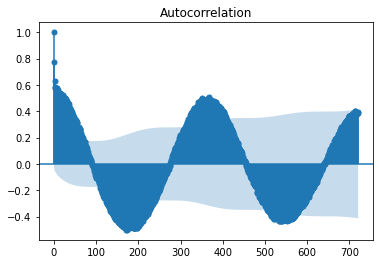

In [130]:
plot_acf(ts, lags=720); #сезонность 365

### Задание 3.

Добавьте в модель следующие дополнительные признаки

* Для всех лагов кроме целевого на каждой строчке матрицы расчитайте среднее и стандартное отклонение (не включайте текущий лаг на данном объекте, чтобы избежать лика информации из будущего).
  
Для всех обьектов добавьте в качестве признаков следующие datetime признаки (см аналогию в modern_approach.ipynb)
1. sin/cos года текущего объекта
2. sin/cos месяца текущего объекта
3. sin/cos дня текущего объекта

Подсказка (получить соответствующие значения можно из аттрибутов обьекта datetime)

In [281]:
import math
from pandas._libs.tslibs.timestamps import Timestamp
import numpy as np

def get_month_sin(timestamp: Timestamp) -> float:
    theta = timestamp.month * (2*math.pi / 12)
    return math.sin(theta)


def get_month_cos(timestamp: Timestamp) -> float:
    theta = timestamp.month * (2*math.pi / 12)
    return math.cos(theta)


def get_day_sin(timestamp: Timestamp) -> float:
    theta = timestamp.day * (2*math.pi / timestamp.days_in_month)
    return math.sin(theta)


def get_day_cos(timestamp: Timestamp) -> float:
    theta = timestamp.day * (2*math.pi / timestamp.days_in_month)
    return math.cos(theta)


def get_dayofweek_sin(timestamp: Timestamp) -> float:
    theta = timestamp.dayofweek * (2*math.pi / 7)
    return math.sin(theta)


def get_dayofweek_cos(timestamp: Timestamp) -> float:
    theta = timestamp.dayofweek * (2*math.pi / 7)
    return math.cos(theta)


def get_hour_sin(timestamp: Timestamp) -> float:
    theta = timestamp.hour * (2*math.pi / 24)
    return math.sin(theta)


def get_hour_cos(timestamp: Timestamp) -> float:
    theta = timestamp.hour * (2*math.pi / 24)
    return math.cos(theta)


def get_minute_sin(timestamp: Timestamp) -> float:
    theta = timestamp.minute * (2*math.pi / 60)
    return math.sin(theta)


def get_minute_cos(timestamp: Timestamp) -> float:
    theta = timestamp.minute * (2*math.pi / 60)
    return math.cos(theta)

def get_year(timestamp: Timestamp) -> int:
    return timestamp.year

def get_std(timestamp: Timestamp) -> float:
    return np.std(df)

def get_mean(DataFrame,k) -> float:
    print ('kwargs-',DataFrame,k)
    return 0#np.mean() 

math_mappers = {
    # 'std': get_std,
    'mean': get_mean

}

data_mappers = {
    'month_sin': get_month_sin,
    'month_cos': get_month_cos,
    'day_sin': get_day_sin,
    'day_cos': get_day_cos,
    'dayofweek_sin': get_dayofweek_sin,
    'dayofweek_cos': get_dayofweek_cos,
    # 'hour_sin': get_hour_sin,
    # 'hour_cos': get_hour_cos,
    # 'minute_sin': get_minute_sin,
    # 'minute_cos': get_minute_cos,
    'year': get_year,
}

In [286]:
def enrich_data(lags_matrix, mappers):
    for name, mapper in mappers.items():
        feature = pd.Series(lags_matrix.index.map(mapper), lags_matrix.index, name=name)
        lags_matrix[name] = feature    
    return lags_matrix

In [291]:
lags_matrix = enrich_data(df, data_mappers)

In [302]:
lags_matrix.head()

,lag_365,lag_364,lag_363,lag_362,lag_361,lag_360,lag_359,lag_358,lag_357,lag_356,...,lag_2,lag_1,lag_0,month_sin,month_cos,day_sin,day_cos,dayofweek_sin,dayofweek_cos,year
data,,,,,,,,,,,,,,,,,,,,,
1981-01-02,17.9,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,...,17.4,17.0,15.0,0.5,0.866025,0.394356,0.918958,-0.433884,-0.900969,1981
1981-01-03,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,...,17.0,15.0,13.5,0.5,0.866025,0.571268,0.820763,-0.974928,-0.222521,1981
1981-01-04,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,...,15.0,13.5,15.2,0.5,0.866025,0.724793,0.688967,-0.781831,0.623490,1981
1981-01-05,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,...,13.5,15.2,13.0,0.5,0.866025,0.848644,0.528964,0.000000,1.000000,1981
1981-01-06,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,25.0,...,15.2,13.0,12.5,0.5,0.866025,0.937752,0.347305,0.781831,0.623490,1981


### Задание 4. 

Разделите на train/test в соотношении примерно 0.7 на 0.3.

Обратите внимание что тест всегда должен быть после трейна, чтобы избежать ликов из будущего, поэтому никакого stratified split

In [295]:
len_test = int (len(lags_matrix)*0.7) #70% обучающая выборка
ts_train, ts_test = lags_matrix[:len_test], lags_matrix[len_test:]

In [296]:
ts_train.shape, ts_test.shape

((2298, 373), (986, 373))

### Задание 5. 

Обучите модель линейной регрессии из sklearn (LinearRegression, Ridge, Lasso)`

In [297]:
from sklearn.linear_model import LinearRegression, Ridge

In [303]:
x = ts_train.drop(columns=['lag_0'])
y = ts_train['lag_0']

In [316]:
# res = LinearRegression()
res = Ridge(alpha=6.0)

In [317]:
res.fit(x, y)

Ridge(alpha=6.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [318]:
res.score(x, y)

0.775805408382974

In [319]:
#test data
x = ts_test.drop(columns=['lag_0'])
y = ts_test['lag_0']
pred = pd.Series(res.predict(x), index=y.index)

In [322]:
from sklearn.metrics import mean_squared_error as mse
mse(y, pred)

3.504188743095698

In [320]:
import plotting
plotting.plot_ts(y, pred, legends=['test','pred'])

Loading BokehJS ...